In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

In [4]:
mnist_train = torchvision.datasets.FashionMNIST(root='./data', 
                                    train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='./data', 
                                    train=False, download=True, transform=transforms.ToTensor())

In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, 
shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, 
shuffle=False)
# 查看数据集信息
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")
print(f"批大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")
print(f"测试批次数: {len(test_loader)}")

训练集大小: 60000
测试集大小: 10000
批大小: 256
训练批次数: 235
测试批次数: 40


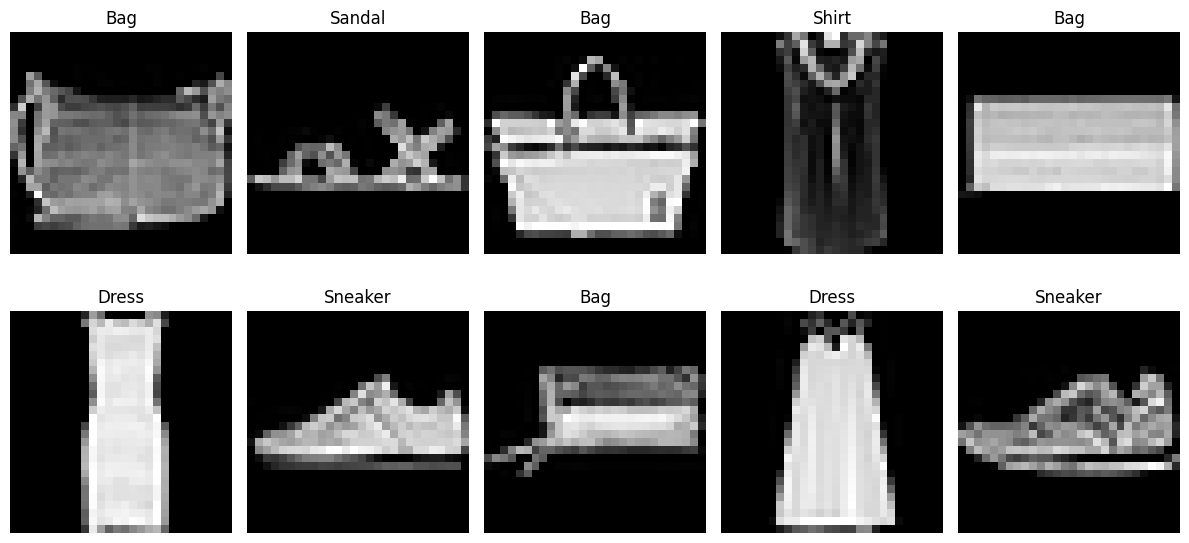

In [6]:
# 获取一个批次的数据
images, labels = next(iter(train_loader))

# 类别名称
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# 可视化样本
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    # 反归一化: image = (image * 0.5) + 0.5
    image = images[i].squeeze().numpy() * 0.5 + 0.5
    plt.imshow(image, cmap='gray')
    plt.title(class_names[labels[i].item()])
    plt.axis('off')
plt.tight_layout()
plt.savefig('fashion_samples.png', dpi=300)
plt.show()

In [7]:
# Softmax 函数实现
def softmax(X):
    """Softmax函数实现"""
    max_vals = torch.max(X, dim=1, keepdim=True)[0] # 减去最大值以提高数值稳定性
    X_exp = torch.exp(X - max_vals)
    partition = torch.sum(X_exp, dim=1, keepdim=True)
    return X_exp / partition

# 交叉熵损失函数实现
def cross_entropy_loss(y_hat, y):
    """交叉熵损失函数实现"""
    # 将标签转换为one-hot编码
    y_onehot = torch.zeros_like(y_hat)
    y_onehot.scatter_(1, y.view(-1, 1), 1)
    
    # 计算损失（添加小常数避免log(0)）
    epsilon = 1e-8
    loss = -torch.sum(y_onehot * torch.log(y_hat + epsilon)) / y_hat.shape[0]
    return loss

# 模型参数初始化
def init_params(input_size, output_size):
    """初始化模型参数"""
    # 权重初始化
    W = torch.normal(0, 0.01, size=(input_size, output_size), requires_grad=True)
    # 偏置初始化
    b = torch.zeros(output_size, requires_grad=True)
    return W, b

# Softmax 回归模型
def softmax_regression(X, W, b):
    """Softmax回归模型"""
    return softmax(torch.matmul(X, W) + b)

In [8]:
# 评估函数
def evaluate_model(data_loader, W, b):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in data_loader:
            # 展平图像
            X = X.view(X.shape[0], -1)
            
            # 前向传播
            y_hat = softmax_regression(X, W, b)
             
            # 计算准确率
            predictions = torch.argmax(y_hat, dim=1)
            correct += (predictions == y).sum().item()
            total += y.size(0)
    
    return correct / total

In [9]:
# 训练函数
from time import time


def train_model(train_loader, test_loader, input_size, output_size, lr=0.1, num_epochs=20):
    """训练Softmax回归模型"""
    # 初始化参数
    W, b = init_params(input_size, output_size)
    
    # 记录训练过程
    train_losses = []
    train_accs = []
    test_accs = []
    learning_rates = []
    
    print(f"{'Epoch':^7} | {'Train Loss':^10} | {'Train Acc':^9} | {'Test Acc':^8} | {'Time (s)':^7}")
    print("-"*60)
    
    for epoch in range(num_epochs):
        epoch_start = time()
        total_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # 训练阶段
        for batch_idx, (X, y) in enumerate(train_loader):
            # 展平图像 (batch_size, 1, 28, 28) -> (batch_size, 784)
            X = X.view(X.shape[0], -1)
            
            # 前向传播
            y_hat = softmax_regression(X, W, b)
            
            # 计算损失
            loss = cross_entropy_loss(y_hat, y)
            total_loss += loss.item() * X.shape[0]
            
            # 计算准确率
            predictions = torch.argmax(y_hat, dim=1)
            correct_train += (predictions == y).sum().item()
            total_train += y.size(0)

            # 计算梯度并更新参数
            loss.backward()
            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad
                W.grad.zero_()
                b.grad.zero_()
        
        # 计算训练损失和准确率
        avg_loss = total_loss / total_train
        train_acc = correct_train / total_train
        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        
        # 在测试集上评估
        test_acc = evaluate_model(test_loader, W, b)
        test_accs.append(test_acc)
        
        # 计算时间
        epoch_time = time() - epoch_start
        
        print(f"{epoch+1:^7} | {avg_loss:^10.4f} | {train_acc:^9.4f} | {test_acc:^8.4f} | {epoch_time:^7.2f}")
    
    return W, b, train_losses, train_accs, test_accs, learning_rates

In [10]:
# 超参数设置
input_size = 28 * 28  # 图像尺寸
output_size = 10      # 类别数
learning_rate = 0.1
num_epochs = 50

# 训练模型
W, b, train_losses, train_accs, test_accs, learning_rates = train_model(
    train_loader, test_loader, 
    input_size, output_size, 
    lr=learning_rate, 
    num_epochs=num_epochs
)

 Epoch  | Train Loss | Train Acc | Test Acc | Time (s)
------------------------------------------------------------
   1    |   0.7860   |  0.7478   |  0.7963  |  3.07  
   2    |   0.5695   |  0.8133   |  0.8116  |  3.03  
   3    |   0.5251   |  0.8248   |  0.8116  |  3.14  
   4    |   0.5004   |  0.8323   |  0.8231  |  3.13  
   5    |   0.4846   |  0.8366   |  0.8268  |  3.10  
   6    |   0.4732   |  0.8408   |  0.8198  |  3.00  
   7    |   0.4645   |  0.8420   |  0.8214  |  3.03  
   8    |   0.4581   |  0.8448   |  0.8313  |  3.01  
   9    |   0.4528   |  0.8460   |  0.8333  |  13.17 
  10    |   0.4472   |  0.8479   |  0.8234  |  28.97 
  11    |   0.4431   |  0.8502   |  0.8218  |  11.52 
  12    |   0.4403   |  0.8499   |  0.8202  |  2.94  
  13    |   0.4363   |  0.8518   |  0.8342  |  2.91  
  14    |   0.4332   |  0.8533   |  0.8217  |  3.03  
  15    |   0.4308   |  0.8522   |  0.8371  |  3.10  
  16    |   0.4281   |  0.8539   |  0.8326  |  2.98  
  17    |   0.4259  

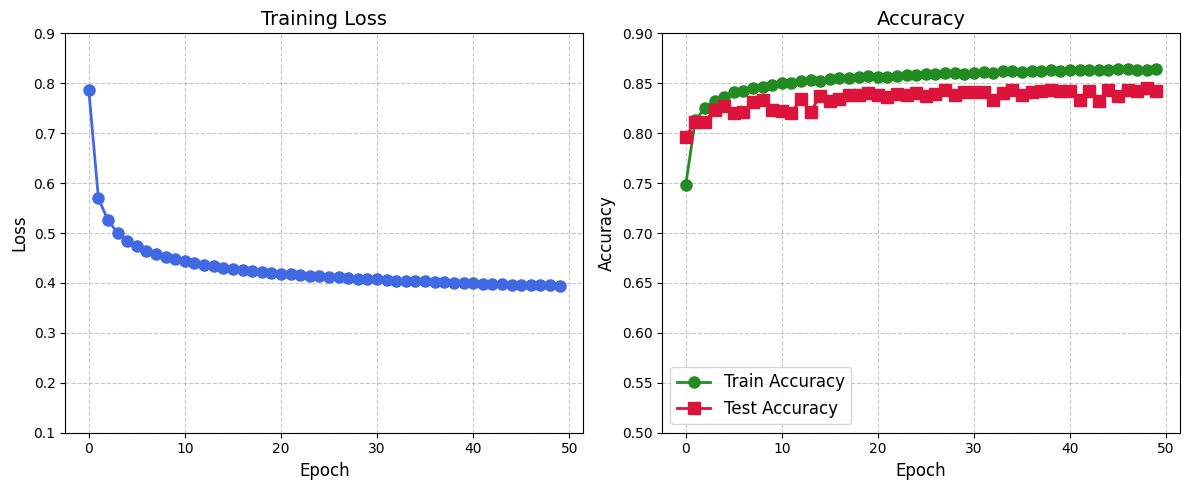

In [11]:
# 可视化结果
def plot_results(train_losses, train_accs, test_accs):
    """绘制训练过程中的损失和准确率曲线"""
    plt.figure(figsize=(12, 5))
    
    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'o-', color='royalblue', linewidth=2, markersize=8)
    plt.title('Training Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.ylim(0.1, 0.9)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, 'o-', label='Train Accuracy', color='forestgreen', linewidth=2, markersize=8)
    plt.plot(test_accs, 's-', label='Test Accuracy', color='crimson', linewidth=2, markersize=8)
    plt.title('Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0.5, 0.9)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('softmax_regression_results.png', dpi=300)
    plt.show()

plot_results(train_losses, train_accs, test_accs)

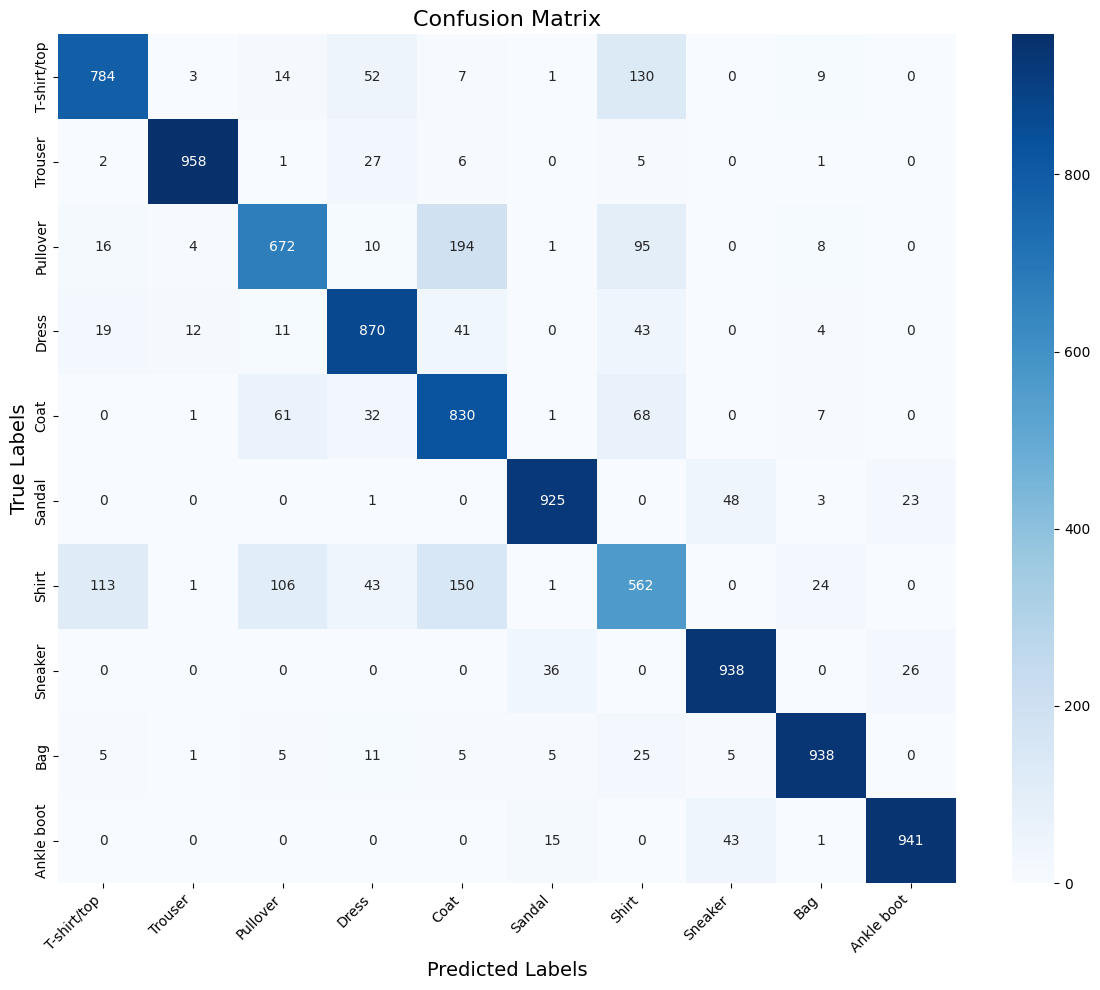

In [12]:
# 最终测试准确率
from sklearn.metrics import confusion_matrix
import seaborn as sns


# 生成混淆矩阵
def plot_confusion_matrix(data_loader, W, b, class_names):
    """绘制混淆矩阵"""
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for X, y in data_loader:
            # 展平图像
            X = X.view(X.shape[0], -1)
            
            # 前向传播
            y_hat = softmax_regression(X, W, b)
            
            # 获取预测结果
            predictions = torch.argmax(y_hat, dim=1)
            all_predictions.extend(predictions.numpy())
            all_labels.extend(y.numpy())
    
    # 创建混淆矩阵
    cm = confusion_matrix(all_labels, all_predictions)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    return cm

# 绘制混淆矩阵
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
cm = plot_confusion_matrix(test_loader, W, b, class_names)

In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
from time import time

In [14]:
# 定义softmax回归模型
class SoftmaxRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegression, self).__init__()
        # 线性层：输入大小为28*28=784，输出大小为10（类别数）
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, x):
        # 展平图像：(batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)
        # 线性变换
        logits = self.linear(x)
        # 不直接应用softmax，因为CrossEntropyLoss会自动处理
        return logits

In [15]:
# 初始化模型、损失函数和优化器
model = SoftmaxRegression(input_size, output_size)

# 交叉熵损失函数，内部已经包含了softmax操作
criterion = nn.CrossEntropyLoss()

# 随机梯度下降优化器
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
# 在测试集上评估模型
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 收集所有预测和标签用于混淆矩阵
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    
    return correct / total, cm

In [17]:
# 训练模型
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    # 记录训练过程中的指标
    train_losses = []
    train_accs = []
    test_accs = []
    print(f"{'Epoch':^7} | {'Train Loss':^10} | {'Train Acc':^9} | {'Test Acc':^8} | {'Time (s)':^7}")
    print("-"*60)
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()  # 设置为训练模式
        start_time = time()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()  # 清零梯度
            loss.backward()        # 反向传播
            optimizer.step()       # 更新参数
            
            # 累加损失
            total_loss += loss.item() * images.size(0)
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # 计算训练集的平均损失和准确率
        avg_train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)
        
        # 在测试集上评估
        model.eval()  # 设置为评估模式
        test_acc, cm = evaluate_model(model, test_loader)
        test_accs.append(test_acc)
        
        # 打印 epoch 信息
        epoch_time = time() - start_time
        print(f"{epoch+1:^7} | {avg_train_loss:^10.4f} | {train_acc:^9.4f} | {test_acc:^8.4f} | {epoch_time:^7.2f}")
    
    return model, train_losses, train_accs, test_accs, cm

In [18]:
model, train_losses, train_accs, test_accs, cm = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

 Epoch  | Train Loss | Train Acc | Test Acc | Time (s)
------------------------------------------------------------
   1    |   0.7888   |  0.7467   |  0.7838  |  3.07  
   2    |   0.5723   |  0.8122   |  0.8113  |  3.18  
   3    |   0.5267   |  0.8241   |  0.8171  |  3.03  
   4    |   0.5017   |  0.8330   |  0.8166  |  3.13  
   5    |   0.4862   |  0.8361   |  0.8202  |  3.01  
   6    |   0.4744   |  0.8404   |  0.8277  |  2.86  
   7    |   0.4651   |  0.8430   |  0.8283  |  2.88  
   8    |   0.4578   |  0.8451   |  0.8313  |  2.94  
   9    |   0.4525   |  0.8456   |  0.8332  |  3.02  
  10    |   0.4468   |  0.8480   |  0.8281  |  6.09  
  11    |   0.4431   |  0.8488   |  0.8320  |  29.35 
  12    |   0.4392   |  0.8507   |  0.8340  |  29.92 
  13    |   0.4358   |  0.8508   |  0.8356  |  29.53 
  14    |   0.4341   |  0.8527   |  0.8361  |  5.32  
  15    |   0.4311   |  0.8521   |  0.8327  |  3.01  
  16    |   0.4282   |  0.8544   |  0.8364  |  2.97  
  17    |   0.4259  

In [19]:
# 可视化结果
def plot_results(train_losses, train_accs, test_accs, cm):
    plt.figure(figsize=(15, 10))
    
    # 绘制损失曲线
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', linewidth=2)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 绘制准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(range(1, len(train_accs)+1), train_accs, 'g-', label='Training Accuracy', linewidth=2)
    plt.plot(range(1, len(test_accs)+1), test_accs, 'r-', label='Test Accuracy', linewidth=2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 绘制混淆矩阵
    plt.subplot(2, 1, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    plt.tight_layout()
    plt.savefig('fashion_mnist_softmax_results.png', dpi=300)
    plt.show()

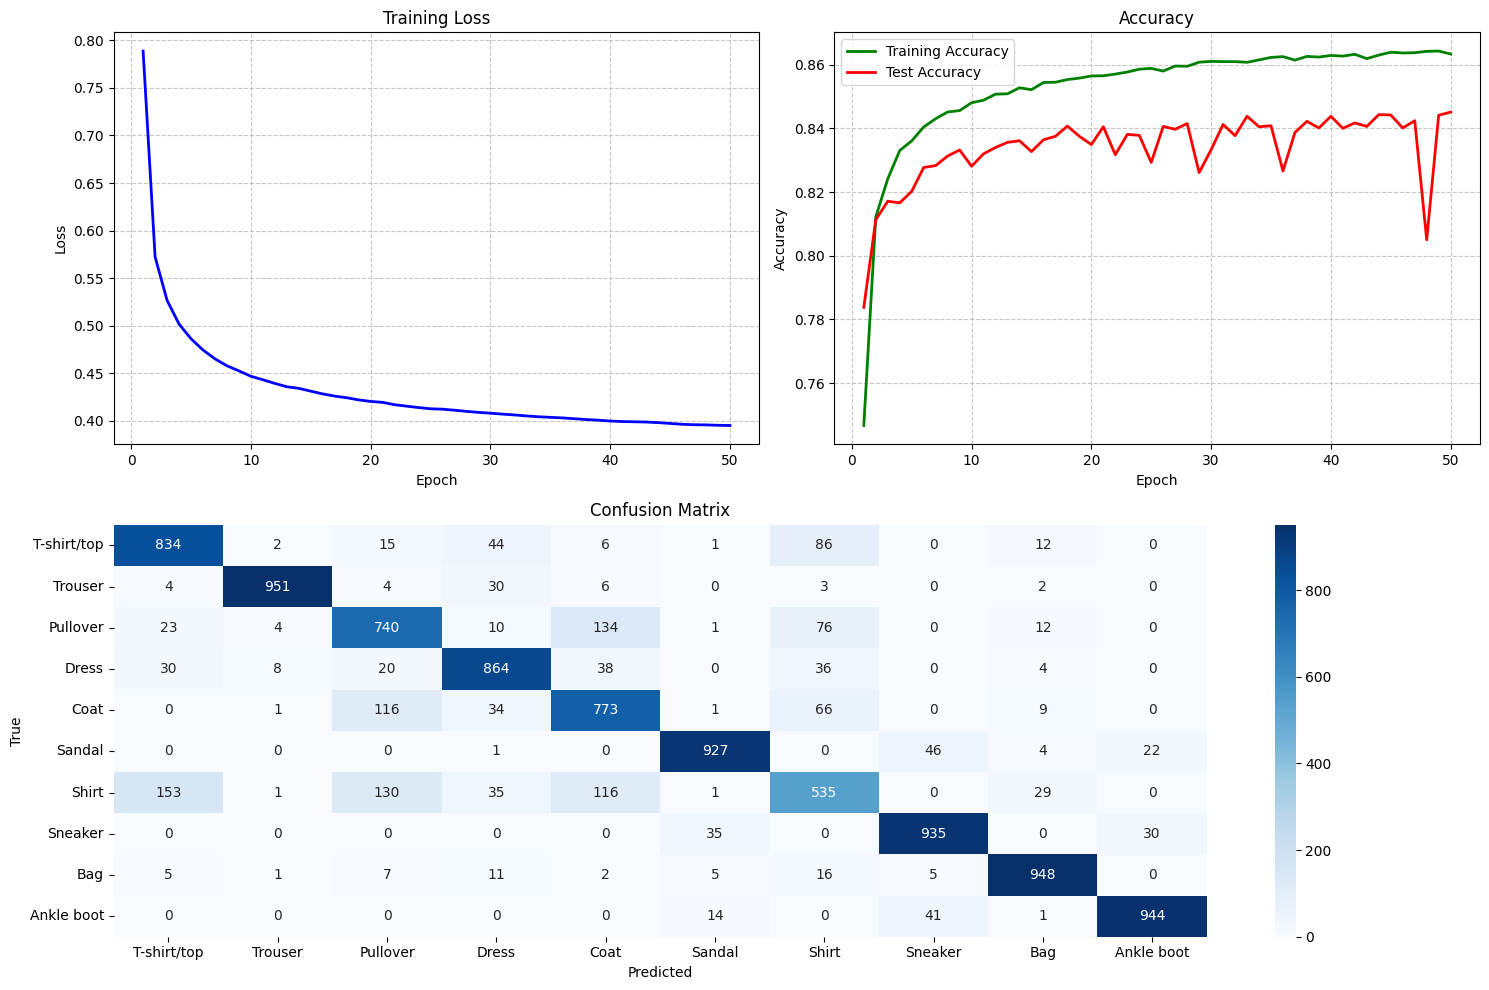

In [20]:
# 提取测试准确率和混淆矩阵
# test_accs = [acc for acc, _ in test_accs_with_cm]
# _, cm = test_accs_with_cm[-1]  # 获取最后一个epoch的混淆矩阵

# 可视化结果
plot_results(train_losses, train_accs, test_accs, cm)